In [ ]:
import os
import csv
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from scipy import stats
from scipy.stats import pearsonr
from matplotlib.ticker import MultipleLocator
import matplotlib.ticker as ticker
from textwrap import wrap
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [ ]:
targets = pd.read_csv('/Cog-Ment/R/g_factor_5_folds/target.csv')
targets.columns

Index(['eid', 'log_RT', 'FIS',
       'Numeric memory:Max digits remembered correctly',
       'log_TMT:Duration to complete numeric path',
       'log_TMT:Duration to complete alphabetic path',
       'SDS:Numb of symbol digit matches made correctly',
       'PAL:Numb of word pairs correctly associated',
       'Tower rearranging:Numb of puzzles correct',
       'Matrix PC: Numb of puzzles correctly solved',
       'log1p_Pairs match:Incorrect matches (round 2)',
       'Picture vocab:Specific cognitive ability',
       'Prosp memory:Initial answer'],
      dtype='object')

In [3]:
targets.columns = ['eid', '(log)Reaction time', 'Fluid intelligence score',
       'Numeric memory: Maximum digits remembered correctly',
       '(log)Trail making test: Duration to complete numeric path',
       '(log)Trail making test: Duration to complete alphabetic path',
       'Symbol digit substitution: Number of correct matches',
       'Paired associate learning: Number of correct pairs',
       'Tower rearranging: Number of puzzles correct',
       'Matrix pattern completion: Number of puzzles correct',
       '(logx+1)Pairs matching: Incorrect matches',
       'Picture vocabulary: Specific cognitive ability',
       'Prospective memory: Initial answer']

## Plot the distribution of cognitive test scores

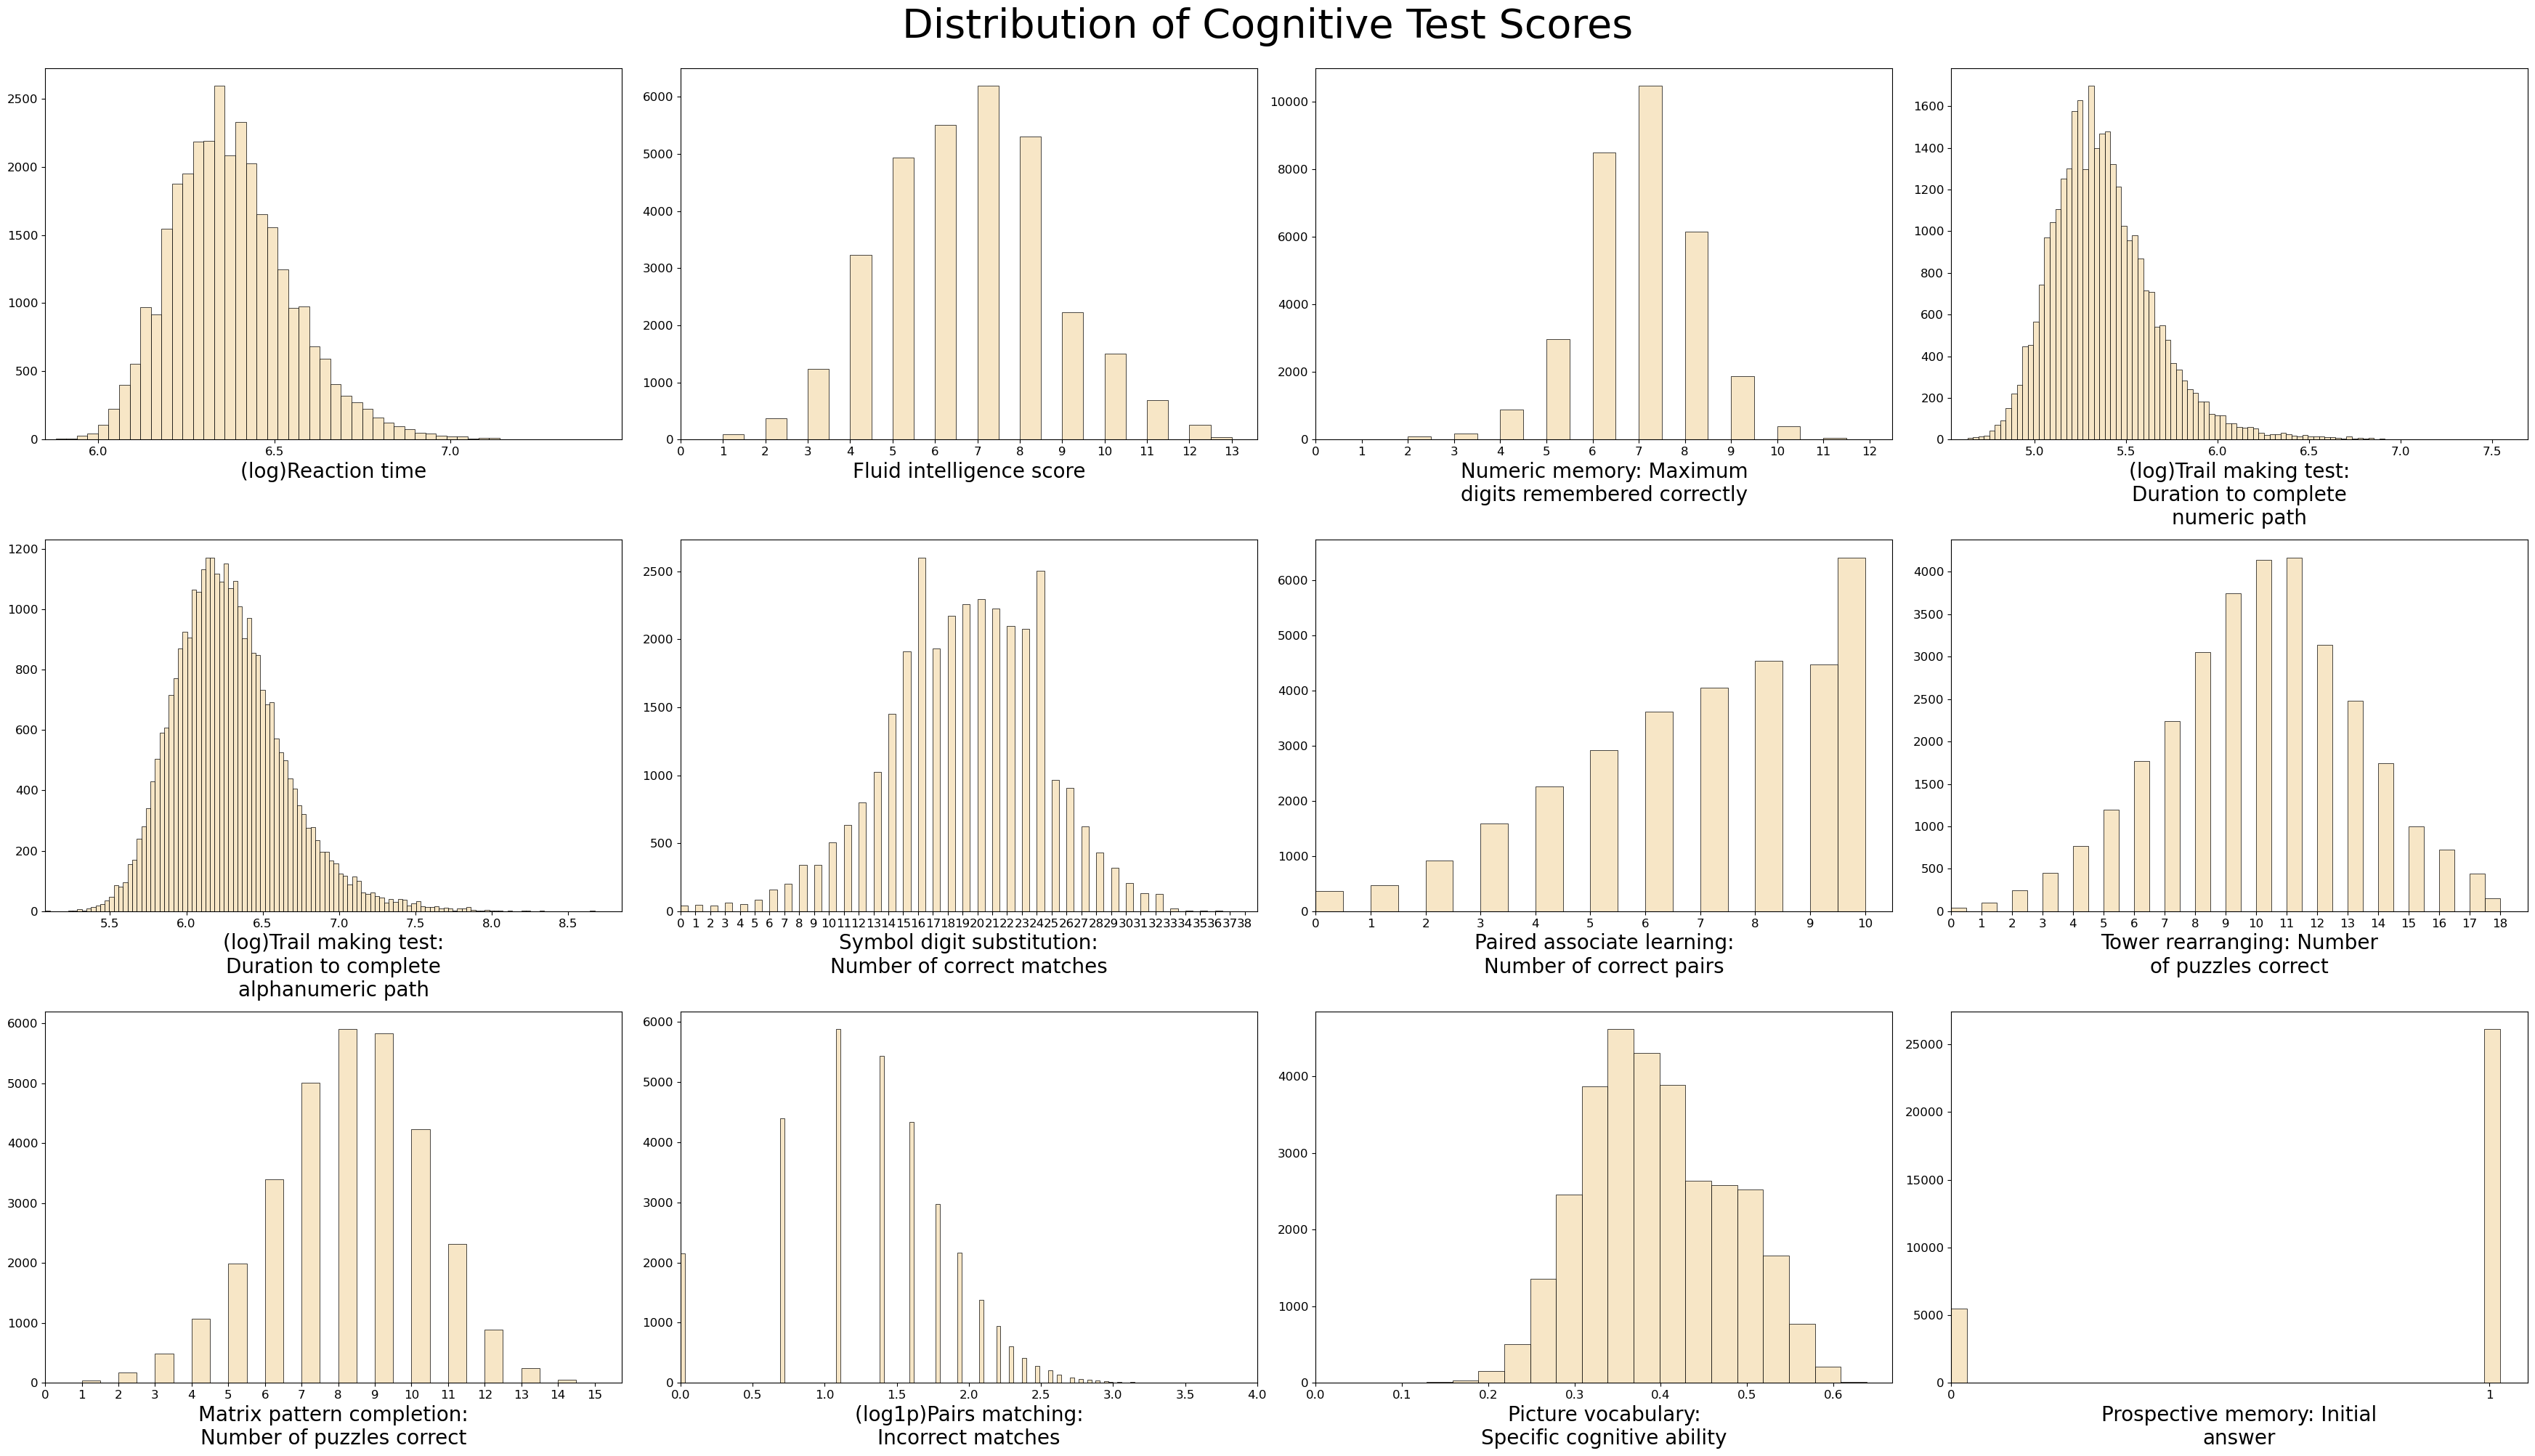

In [ ]:
# Cognitive test score distribution
warnings.simplefilter(action='ignore', category=FutureWarning)

fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(35, 20))
columns = targets.drop(columns='eid').columns
axes = axes.flatten()
for i, col in enumerate(columns):
    column_data = targets.drop(columns='eid')[col]

    binwidth = 0.03 if col != 'Matrix pattern completion: Number of puzzles correct' and col != 'Fluid intelligence score' and col != 'Numeric memory: Maximum digits remembered correctly' and col != 'Paired associate learning: Number of correct pairs' and col != 'Tower rearranging: Number of puzzles correct' and col != 'Symbol digit substitution: Number of correct matches' else 0.5
    sns.histplot(column_data, ax=axes[i], color='wheat', binwidth=binwidth, linewidth=0.5)
    axes[i].tick_params(axis='x', labelsize=12)

    
    wrapped_col = '\n'.join(wrap(col, width=27)) # Wrap the column label at spaces to keep words uninterrupted

    axes[i].set_xlabel(wrapped_col, fontsize=20)
    axes[i].set_ylabel(None)
    axes[i].tick_params(axis='y', labelsize=12)
    axes[i].tick_params(axis='x', labelsize=12)

    axes[i].xaxis.set_major_locator(ticker.MultipleLocator(1))

    if col == 'Picture vocabulary: Specific cognitive ability':
        axes[i].xaxis.set_major_locator(ticker.MultipleLocator(0.1))
    elif col in ['(log)Trail making test: Duration to complete alphanumeric path', '(log)Trail making test: Duration to complete numeric path', '(log)Reaction time', '(log1p)Pairs matching: Incorrect matches']:
        axes[i].xaxis.set_major_locator(ticker.MultipleLocator(0.5))
    else:
        axes[i].xaxis.set_major_locator(ticker.MultipleLocator(1))

    #axes[i].yaxis.set_major_locator(locator) # y axis tick interval

    axes[i].set_xlim(left=0) if col != '(log)Reaction time' and col != '(log)Trail making test: Duration to complete numeric path' and col !='(log)Trail making test: Duration to complete alphanumeric path' else axes[i].set_xlim(left=column_data.min()) 

plt.suptitle('Distribution of Cognitive Test Scores', fontsize=40, y=1.0)
plt.subplots_adjust(hspace=0.6, wspace=0.5)
plt.tight_layout()
plt.show()

## Plot the correlation between cognitive test scores

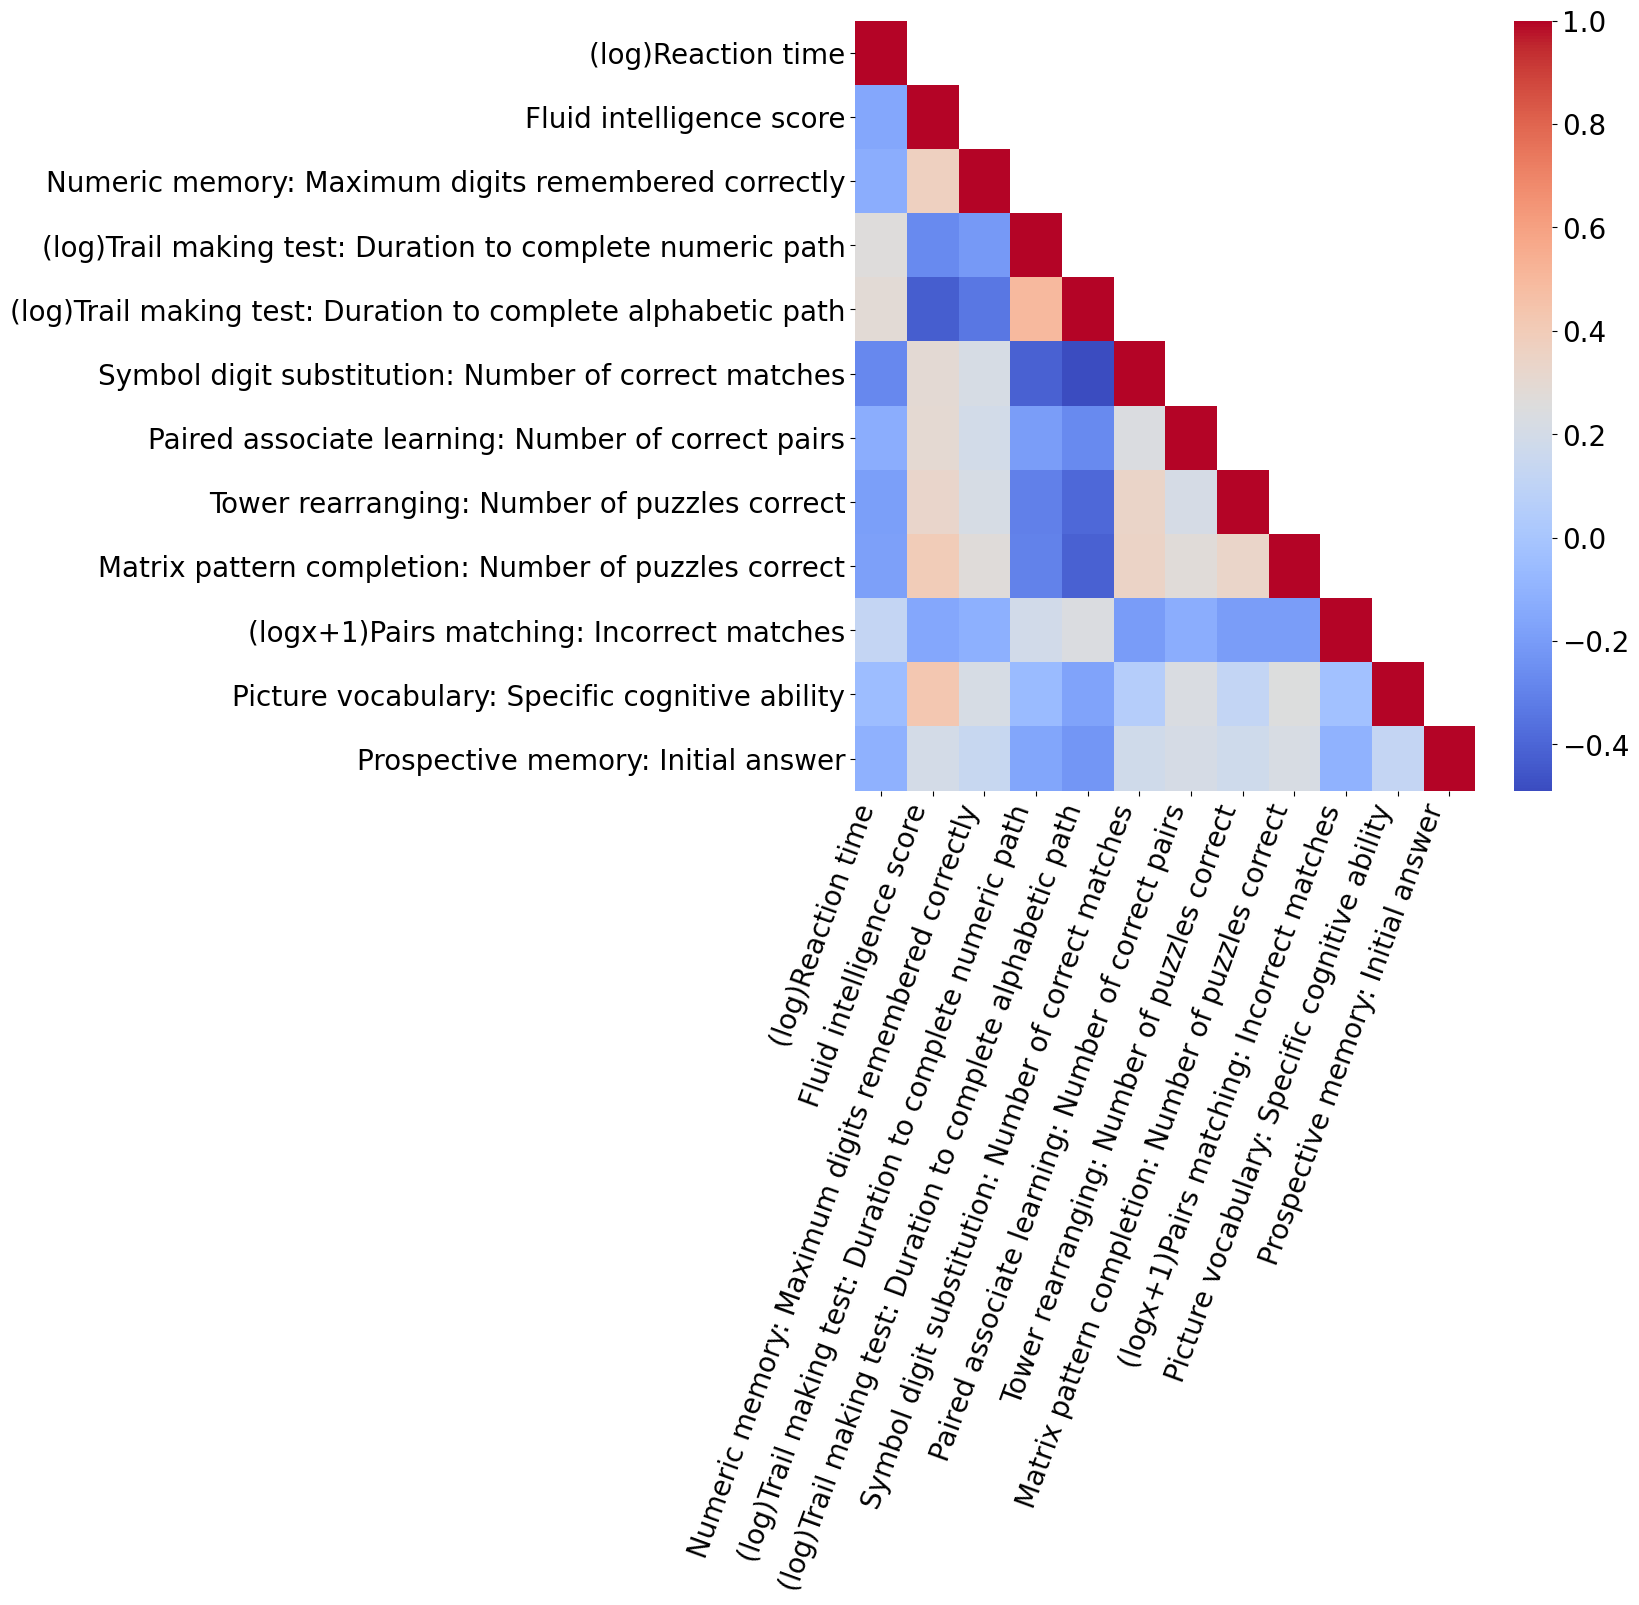

In [4]:
# Correlation plot: Lower triangular part
correlation_matrix = targets.drop(columns='eid').corr(method='pearson')
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool), k=1)
plt.figure(figsize=(10, 10))
plot = sns.heatmap(correlation_matrix, cmap='coolwarm', fmt=".2f",
                   xticklabels=correlation_matrix.columns,
                   yticklabels=correlation_matrix.columns,
                   mask=mask) # Apply mask
plot.set_xticklabels(plot.get_xticklabels(), rotation=70, ha='right', fontsize=20)
plt.tick_params(labelsize=20)
cbar = plot.collections[0].colorbar
cbar.ax.tick_params(labelsize=20)

plt.show()

## Compute correlations between cognitive test scores

In [81]:
# Correlations between test scores
correlation_matrix = targets.drop(columns='eid').corr(method='pearson')
# Create a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool), k=1)
# Apply the mask to get the lower triangle of the correlation matrix
lower_triangle = pd.DataFrame(correlation_matrix.mask(mask)) #or lower_triangle = correlation_matrix.where(~mask)
column_names = ['(log)RT', 'FIS', 'NM', '(log)TMT-numeric', '(log)TMT-alphabetic', 'SDS', 'PAL', 'Tower Rear.', 'Matrix PC', '(log1p)Pairs Match.', 'Picture Vocab.', 'Prospective Mem.']
lower_triangle.columns = column_names
lower_triangle.index = column_names
lower_triangle.round(2)

,(log)RT,FIS,NM,(log)TMT-numeric,(log)TMT-alphabetic,SDS,PAL,Tower Rear.,Matrix PC,(log1p)Pairs Match.,Picture Vocab.,Prospective Mem.
(log)RT,1.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FIS,-0.15,1.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NM,-0.12,0.37,1.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
(log)TMT-numeric,0.26,-0.27,-0.21,1.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
(log)TMT-alphabetic,0.29,-0.43,-0.34,0.50,1.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SDS,-0.27,0.29,0.22,-0.42,-0.49,1.00,NaN,NaN,NaN,NaN,NaN,NaN
PAL,-0.12,0.30,0.19,-0.19,-0.27,0.24,1.00,NaN,NaN,NaN,NaN,NaN
Tower Rear.,-0.19,0.33,0.22,-0.30,-0.39,0.34,0.21,1.00,NaN,NaN,NaN,NaN
Matrix PC,-0.19,0.40,0.27,-0.30,-0.41,0.35,0.28,0.33,1.00,NaN,NaN,NaN
(log1p)Pairs Match.,0.13,-0.16,-0.11,0.19,0.24,-0.20,-0.13,-0.20,-0.19,1.00,NaN,NaN


In [79]:
# Extract p-values
p_values = pd.DataFrame(index=column_names, columns=column_names)
for i in range(targets.drop(columns='eid').shape[1]):
    for j in range(i+1, targets.drop(columns='eid').shape[1]):
        _, p_value = pearsonr(targets.drop(columns='eid').iloc[:, i], targets.drop(columns='eid').iloc[:, j])
        p_values.iloc[i, j] = p_value
        p_values.iloc[j, i] = p_value 

mask = np.triu(np.ones_like(p_values, dtype=bool), k=1)
lower_triangle_p_values = p_values.mask(mask)

for col in lower_triangle_p_values.columns:
    lower_triangle_p_values[col] = lower_triangle_p_values[col].apply(lambda x: '{:.3f}'.format(x) if pd.notnull(x) else x)
lower_triangle_p_values

,(log)RT,FIS,NM,(log)TMT-numeric,(log)TMT-alphabetic,SDS,PAL,Tower Rear.,Matrix PC,(log1p)Pairs Match.,Picture Vocab.,Prospective Mem.
(log)RT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FIS,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NM,0.000,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
(log)TMT-numeric,0.000,0.000,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
(log)TMT-alphabetic,0.000,0.000,0.000,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SDS,0.000,0.000,0.000,0.000,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PAL,0.000,0.000,0.000,0.000,0.000,0.000,NaN,NaN,NaN,NaN,NaN,NaN
Tower Rear.,0.000,0.000,0.000,0.000,0.000,0.000,0.000,NaN,NaN,NaN,NaN,NaN
Matrix PC,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,NaN,NaN,NaN,NaN
(log1p)Pairs Match.,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,NaN,NaN,NaN


# Split the whole dataset into 5 folds

In [ ]:
kf = KFold(n_splits = 5, shuffle = True, random_state = 0)
# Split the data set into train and test, using random folds, and save datasets and IDs for each split
directory = "/txt_no_colnames/"
# Use a for loop to save each train and test set for each fold
for fold, (train_index, test_index) in enumerate(kf.split(np.array(targets))):
    print("TRAIN:", train_index, "TEST:", test_index)

    # Split the data into train and test sets
    y_train, y_test = np.array(targets)[train_index], np.array(targets)[test_index]
    # Convert to a data frame
    y_train_df, y_test_df = pd.DataFrame(y_train, columns = targets.columns).drop(columns=['eid']), pd.DataFrame(y_test, columns = targets.columns).drop(columns=['eid'])
    # Save
    y_train_df.to_csv(f'/fold_{fold}/train_fold_{fold}.csv', index=False)
    y_test_df.to_csv(f'/fold_{fold}/test_fold_{fold}.csv', index=False)


    # Scale
    scaler = StandardScaler()
    y_train_scaled = scaler.fit_transform(y_train)
    y_test_scaled = scaler.transform(y_test)
    # Convert to a data frame
    y_train_scaled_df, y_test_scaled_df = pd.DataFrame(y_train_scaled, columns = targets.columns).drop(columns=['eid']), pd.DataFrame(y_test_scaled, columns = targets.columns).drop(columns=['eid'])
    # Save
    y_train_scaled_df.to_csv(f'/fold_{fold}/train_scaled_fold_{fold}.csv', index=False)
    y_test_scaled_df.to_csv(f'/fold_{fold}/test_scaled_fold_{fold}.csv', index=False)


    # Extract the 'eid' column for each train and test set and save as csv
    y_train_id = y_train[:, 0]
    y_test_id = y_test[:, 0]
    # Convert to a data frame
    y_train_id_df, y_test_id_df = pd.DataFrame(y_train_id, columns = ['eid']), pd.DataFrame(y_test_id, columns = ['eid'])
    # Save
    y_train_id_df.to_csv(f'/fold_{fold}/train_id_fold_{fold}.csv', index=False)
    y_test_id_df.to_csv(f'/fold_{fold}/test_id_fold_{fold}.csv', index=False)
    
    
    #1 Create the file name for each train and test set using the fold number
    train_file = "train_" + str(fold) + ".csv"
    test_file = "test_" + str(fold) + ".csv"
    # Use the os.path.join function to create the full file path for each file
    train_path = os.path.join(directory, train_file)
    test_path = os.path.join(directory, test_file)
    # Save the train and test sets as txt
    np.savetxt(train_path, y_train, delimiter=",")
    np.savetxt(test_path, y_test, delimiter=",")

    #2 Create the file name for each train and test set using the fold number
    train_file_scaled = "train_scaled_" + str(fold) + ".csv"
    test_file_scaled = "test_scaled_" + str(fold) + ".csv"
    # Use the os.path.join function to create the full file path for each file
    train_path_scaled = os.path.join(directory, train_file_scaled)
    test_path_scaled = os.path.join(directory, test_file_scaled)
    # Save scaled files as txt
    np.savetxt(train_path_scaled, y_train_scaled, delimiter=",")
    np.savetxt(test_path_scaled, y_test_scaled, delimiter=",")

    #3 Create the file name for each train and test set using the fold number
    train_id = "train_id_" + str(fold) + ".csv"
    test_id = "test_is_" + str(fold) + ".csv"
    # Use the os.path.join function to create the full file path for each file
    train_path_id = os.path.join(directory, train_id)
    test_path_id = os.path.join(directory, test_id)
    # Save ids as txt
    np.savetxt(train_path_id, y_train_id)
    np.savetxt(test_path_id, y_test_id)

# Demographics

In [ ]:
# Upload demographics variables
basic_confounds_min = pd.read_csv('/basic_confounds_min.csv').drop(columns='Date of attending assessment centre')
participant_age = basic_confounds_min[['eid', 'Sex', 'Age when attended assessment centre']].merge(targets['eid'])
print(basic_confounds_min.columns)
print(participant_age.columns)

Index(['eid', 'Sex', 'Age when attended assessment centre', 'Age2', 'Age*Sex',
       'Age2*Sex', 'UK Biobank assessment centre_11025.0',
       'UK Biobank assessment centre_11026.0',
       'UK Biobank assessment centre_11027.0',
       'UK Biobank assessment centre_11028.0'],
      dtype='object')
Index(['eid', 'Sex', 'Age when attended assessment centre'], dtype='object')


0 = Female;
1 = Male

In [65]:
print('Age when attended assessment centre, mean:', participant_age['Age when attended assessment centre'].mean().round(2), 'SD:', f"{participant_age['Age when attended assessment centre'].std():.3f}")
print('Age max range:', participant_age['Age when attended assessment centre'].max())
print('Age min range:', participant_age['Age when attended assessment centre'].min())
print('Proportion of males:', (participant_age['Sex'].value_counts()[1] / len(participant_age['Sex']) * 100).round(2))
print('Proportion of females:', (participant_age['Sex'].value_counts()[0] / len(participant_age['Sex']) * 100).round(2))

Sex
0    16232
1    15381
Name: count, dtype: int64
Age when attended assessment centre, mean: 64.51 SD: 7.655
Age max range: 83.0
Age min range: 46.0
Proportion of males: 48.65
Proportion of females: 51.35


In [ ]:
# Get mean demographic data for each fold
folds = ["0", "1", "2", "3", "4"]
for fold in folds:
    
    y_train = pd.read_csv(f'/fold_{fold}/train_id_fold_{fold}.csv')
    y_test = pd.read_csv(f'/fold_{fold}/test_id_fold_{fold}.csv')

    conf_train, conf_test = pd.merge(participant_age, y_train['eid'], on='eid'), pd.merge(participant_age, y_test['eid'], on='eid')
    print('TRAINING SET')
    print(f'Number of participants in fold {fold}:', conf_train.shape)
    print(f'Mean age in fold {fold}:', conf_train['Age when attended assessment centre'].mean().round(2), f'SD for age in fold {fold}:', '{0:.3f}'.format(conf_train['Age when attended assessment centre'].std()))
    print(f'Proportion of females in fold {fold}:',  (conf_train['Sex'].value_counts()[0] / len(conf_train['Sex']) * 100).round(2))

    print('TEST SET')
    print(f'Number of participants in fold {fold}:', conf_test.shape)
    print(f'Mean age in fold {fold}:', conf_test['Age when attended assessment centre'].mean().round(2), f'SD for age in fold {fold}:', '{0:.3f}'.format(conf_test['Age when attended assessment centre'].std()))
    print(f'Proportion of females in fold {fold}:',  (conf_test['Sex'].value_counts()[0] / len(conf_test['Sex']) * 100).round(2))

TRAINING SET
Number of participants in fold 0: (25290, 3)
Mean age in fold 0: 64.52 SD for age in fold 0: 7.635
Proportion of females in fold 0: 51.39
TEST SET
Number of participants in fold 0: (6323, 3)
Mean age in fold 0: 64.48 SD for age in fold 0: 7.735
Proportion of females in fold 0: 51.16
TRAINING SET
Number of participants in fold 1: (25291, 3)
Mean age in fold 1: 64.53 SD for age in fold 1: 7.663
Proportion of females in fold 1: 51.19
TEST SET
Number of participants in fold 1: (6322, 3)
Mean age in fold 1: 64.44 SD for age in fold 1: 7.624
Proportion of females in fold 1: 51.96
TRAINING SET
Number of participants in fold 2: (25290, 3)
Mean age in fold 2: 64.53 SD for age in fold 2: 7.656
Proportion of females in fold 2: 51.38
TEST SET
Number of participants in fold 2: (6323, 3)
Mean age in fold 2: 64.45 SD for age in fold 2: 7.649
Proportion of females in fold 2: 51.19
TRAINING SET
Number of participants in fold 3: (25290, 3)
Mean age in fold 3: 64.5 SD for age in fold 3: 7.65

In [ ]:
# Create a table with demographics data for each fold
results_list = []

folds = ["0", "1", "2", "3", "4"]
for fold in folds:
    
    y_train = pd.read_csv(f'/fold_{fold}/train_id_fold_{fold}.csv')
    y_test = pd.read_csv(f'/fold_{fold}/test_id_fold_{fold}.csv')

    conf_train, conf_test = pd.merge(participant_age, y_train['eid'], on='eid'), pd.merge(participant_age, y_test['eid'], on='eid')
    train_results = {
        'Fold': fold,
        'Set': 'Training',
        'Number of Participants': conf_train.shape[0],
        'Mean Age': conf_train['Age when attended assessment centre'].mean().round(2),
        'Age SD': '{0:.3f}'.format(conf_train['Age when attended assessment centre'].std()),
        'Proportion of Females (%)': (conf_train['Sex'].value_counts()[0] / len(conf_train['Sex']) * 100).round(2)
    }
    results_list.append(train_results)
    
    # Store test set results in a dictionary and append to the list
    test_results = {
        'Fold': fold,
        'Set': 'Test',
        'Number of Participants': conf_test.shape[0],
        'Mean Age': conf_test['Age when attended assessment centre'].mean().round(2),
        'Age SD': '{0:.3f}'.format(conf_test['Age when attended assessment centre'].std()),
        'Proportion of Females (%)': (conf_test['Sex'].value_counts()[0] / len(conf_test['Sex']) * 100).round(2)
    }
    results_list.append(test_results)
results_df = pd.DataFrame(results_list)
results_df.to_csv('/folds_summary.csv', index=False)